In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils

from tqdm import tqdm
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
def init(embeddings_type = 'w2v'): # function to load word embedding only once 
    if embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings(w2v_path)
    else:
        raise NameError('Invalid embedding type {}'.format(embeddings_type))
        
def get_embeddings(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

def load_w2v_embeddings(path):
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray(BaseEstimator, TransformerMixin): # Transformer for transforming given data into undersoodable form for neural network
    def __init__(self, dimensions, steps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = steps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in tokens if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i <self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, sentences, y=None):
        
        if self.w2v == None:
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        sentences = [eval(i) for i in sentences]
        return np.array([self._transform(' '.join(i)) for i in sentences])
    
def plot_training(history): # plot training history
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, input_shape, kernel_size=3): 
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(input_shape, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape = (input_shape, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

In [3]:
class NeuralNet(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, model, name='', validation_size=0.1, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2) # early stopping callback
        self.checkpointer = ModelCheckpoint(filepath='{}_{}.h5'.format(name,
                                                                       time.time()), 
                                            verbose=1, 
                                            save_best_only=True) # save the best model
        self.tensorboard = TensorBoard(log_dir="logs/{}-{}".format(name,time.time())) # show results in the tensorboard
        self.batchsize = batchsize
        self.epochs = epochs
        self.validation_size = validation_size
        
    def fit(self, X, y):
        
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=self.validation_size, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.checkpointer, 
                                            self.early_stopping, 
                                            self.tensorboard] if self.validation_size != 0
                                else [self.checkpointer, self.tensorboard])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [4]:
data_path = 'data/Data - sentiment classification.csv'
w2v_path = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

In [ ]:
df = pd.read_csv(data_path, sep = '\t').drop('id', axis=1)
y = df.loc[:, 'sentiment'].values
x = df.loc[:, 'tokens'].values

encoder = LabelEncoder() # transform y into (-1, 3) shape
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.33, random_state=42)

### Simple LSTM

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Lazy loading embeddings...
Instructions for updating:
Use tf.cast instead.
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 5s 207us/step - loss: 0.3492 - acc: 0.8421 - val_loss: 0.2628 - val_acc: 0.8815

Epoch 00001: val_loss improved from inf to 0.26278, saving model to simple_LSTM_1551121859.787858.h5
Epoch 2/10
24963/24963 [==============================] - 7s 263us/step - loss: 0.2444 - acc: 0.8893 - val_loss: 0.2556 - val_acc: 0.8880

Epoch 00002: val_loss improved from 0.26278 to 0.25562, saving model to simple_LSTM_1551121859.787858.h5
Epoch 3/10
24963/24963 [==============================] - 6s 235us/step - loss: 0.2147 - acc: 0.9037 - val_loss: 0.2311 - val_acc: 0.8992

Epoch 00003: val_loss improved from 0.25562 to 0.23105, saving mod

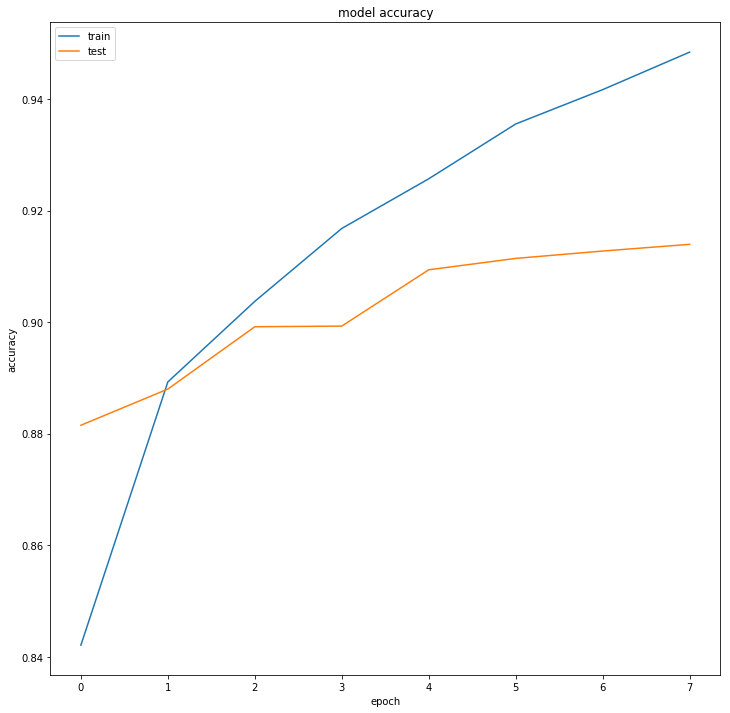

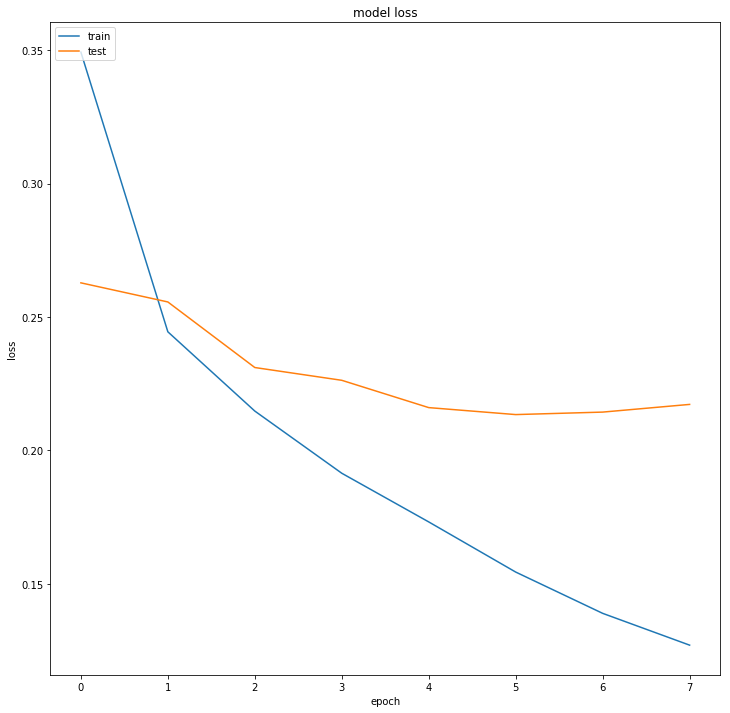

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100,10)),
    ('nn', NeuralNet(create_simple_LSTM_model(10), 'simple_LSTM')),
])  # written classes can be used with sklearn Pipeline class

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1)) # predict on test set

0.8630507978334065

### LSTM

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 12s 498us/step - loss: 0.3296 - acc: 0.8501 - val_loss: 0.2631 - val_acc: 0.8796

Epoch 00001: val_loss improved from inf to 0.26313, saving model to not_simple_LSTM_1551122048.0259163.h5
Epoch 2/10
24963/24963 [==============================] - 11s 448us/step - loss: 0.2500 - acc: 0.8848 - val_loss: 0.2449 - val_acc: 0.8902

Epoch 00002: val_loss improved from 0.26313 to 0.24490, saving model to not_simple_LSTM_1551122048.0259163.h5
Epoch 3/10
24963/24963 [==============================] - 11s 434us/step - loss: 0.2276 - acc: 0.8958 - val_loss: 0.2305 - val_acc: 0.8992

Epoch 00003: val_loss improved from 0.24490 to 0.23054, saving model to not_simple_LSTM_1551122048.0259163.h5
Epoch 4/10
24963/24963 [==============================] - 12s 487us/step - loss: 0.2077 - acc: 0.9068 - val_loss: 0.2243 - val_acc: 0.9019

Epoch 00004: val_loss improved from 0.

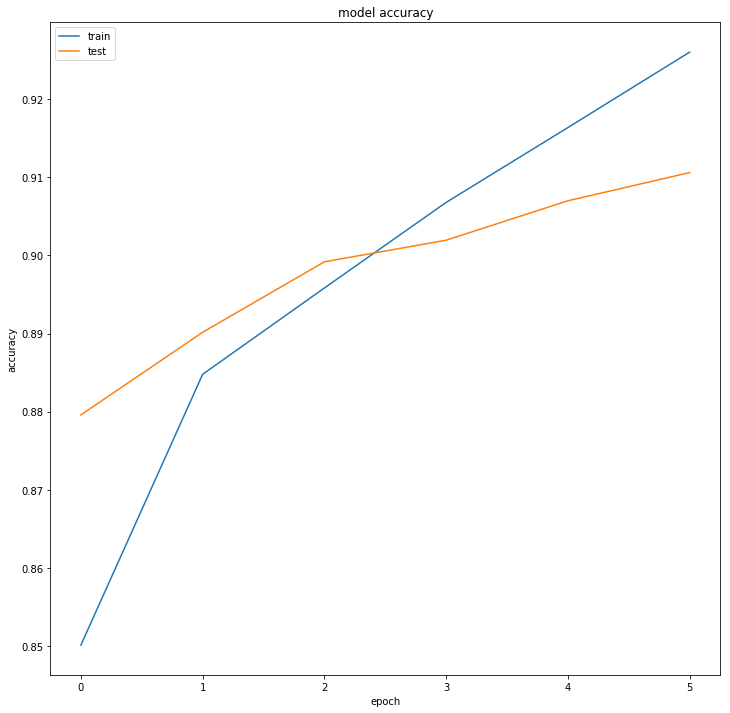

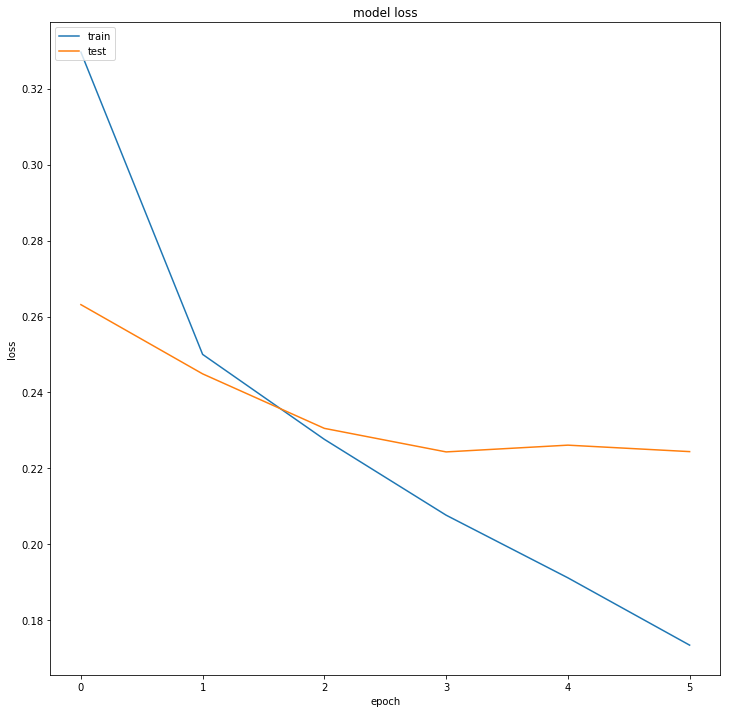

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model(10), 'not_simple_LSTM')),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.8549260723173767

### Conv1d

In [ ]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_conv_model(0.3, 10), 'conv_1d')),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples


In [ ]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))